In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import random
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pickle
import ray
from ray import tune
import sklearn as sk
import torch

from genome_embeddings import corrupt
from genome_embeddings import data_viz
from genome_embeddings import evaluate
from genome_embeddings import models
from genome_embeddings import pre_process
from genome_embeddings import trainable # import before ray (?)

In [3]:
mode = "CC" # "CC" | "Desktop"
# must change local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR"
# local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_22-09-2020//TUNE_RESULT_DIR"

if mode == "Desktop":
    settings = Namespace(
        DATA_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/data/', 
        SAVE_FP = '/Users/natasha/Desktop/',
        num_epochs = 2,
        num_cpus=5, 
        replacement_threshold = 0.5, # probability over which binarizer converts to a 1
        num_corruptions = 100, # number of corrupted versions of a genome to produce
    )
elif mode == "CC":
    settings = Namespace(
        DATA_FP = '/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_01-10-2020/',
        SAVE_FP = '/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_01-10-2020/',
        num_epochs = 2,
        num_cpus=5, 
        replacement_threshold = 0.5, # probability over which binarizer converts to a 1
        num_corruptions = 100, # number of corrupted versions of a genome to produce
    )
    

# Load data needed to make corrupted train + test datasets

In [4]:
create_new = False
from_scratch = False # controls where in creation process to jump in

# Create list of which genomes from KEGG to include in dataset
tla_to_tnum, keepers = pre_process.genomes2include()
org_to_kos, n_kos_tot, all_kos = pre_process.load_kos(tla_to_tnum)
org_to_mod_to_kos, mod_sets = pre_process.load_mods()
mod_to_kos = pre_process.create_mod_to_kos(org_to_mod_to_kos)

if create_new:
    if from_scratch:
        # Load list mods and KOs per genome
        data, genome_order = pre_process.make_tensor(org_to_mod_to_kos, org_to_kos, n_kos_tot, tla_to_tnum, all_kos)
        torch.save(data, "/Users/natasha/Desktop/kegg_v2.pt")
        torch.save(genome_order, "/Users/natasha/Desktop/genome_order.pt")
    else:
        # load data -- tensor (genomes + which KOs are encoded) + genome_order in tensor (tla)
        data = torch.load("/Users/natasha/Desktop/kegg_v2.pt")
        genome_order = torch.load("/Users/natasha/Desktop/genome_order.pt")
    
    # Create test-train split
    train_genomes, test_genomes = pre_process.train_test_split(keepers) # list of IDs to keep
    train_data = pre_process.prep_data(train_genomes, all_kos, org_to_kos, "train")
    test_data = pre_process.prep_data(test_genomes, all_kos, org_to_kos, "test")
    
    torch.save(all_kos, "/Users/natasha/Desktop/all_kos_2020-09-29.pt")
    torch.save(org_to_mod_to_kos, "/Users/natasha/Desktop/org_to_mod_to_kos_2020-09-29.pt")
    torch.save(train_data, "/Users/natasha/Desktop/kegg_v2_train_2020-09-29.pt")
    torch.save(test_data, "/Users/natasha/Desktop/kegg_v2_test_2020-09-29.pt")
    torch.save(train_genomes, "/Users/natasha/Desktop/kegg_v2_train_genomes_2020-09-29.pt")
    torch.save(test_genomes, "/Users/natasha/Desktop/kegg_v2_test_genomes_2020-09-29.pt")
else:
    all_kos = torch.load("/Users/natasha/Desktop/all_kos_2020-09-29.pt")
    org_to_mod_to_kos = torch.load("/Users/natasha/Desktop/org_to_mod_to_kos_2020-09-29.pt")
    train_data = torch.load("/Users/natasha/Desktop/kegg_v2_train_2020-09-29.pt")
    test_data = torch.load("/Users/natasha/Desktop/kegg_v2_test_2020-09-29.pt")
    train_genomes = torch.load("/Users/natasha/Desktop/kegg_v2_train_genomes_2020-09-29.pt")
    test_genomes = torch.load("/Users/natasha/Desktop/kegg_v2_test_genomes_2020-09-29.pt")

mod_to_ko_clean = pre_process.clean_kos(mod_sets)

Total number of bacterial genomes in dataset: 2718
Total number of KOs in dataset: 9874


In [5]:
train_data.shape, test_data.shape

((2430, 9874), (288, 9874))

# Data exploration

In [6]:
# mod = 'M00001'
# a = list(mod_sets[mod].values())
# a.sort(reverse=True)
# x_labels = [i for i in range(len(mod_sets[mod].values()))]
# plt.bar(x_labels, a)
# plt.yscale('log')
# plt.title("Variants of module "+mod)
# plt.xlabel("Variant (n="+str(len(mod_sets[mod].values()))+" )")
# plt.ylabel("Count across all genomes (n="+str(len(org_to_mod_to_kos))+")")
# print(max(mod_sets[mod].values()), len(a))

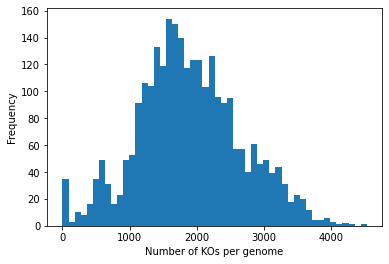

In [7]:
# Plot the number of KOs encoded by each genome
plt.hist([len(org_to_kos[i]) for i in org_to_kos], 50)
plt.xlabel("Number of KOs per genome")
plt.ylabel("Frequency")
plt.savefig("/Users/natasha/Desktop/fig.png")

In [74]:
lens = [len(org_to_kos[i]) for i in org_to_kos if len(org_to_kos[i]) >= 500]
print(np.median(lens), min(lens), max(lens))

1870.0 501 4536


In [8]:
# # Plot the number of modules encoded by each genome
# n_genomes = len(org_to_mod_to_kos)
# temp = [list(org_to_mod_to_kos[i].keys()) for i in org_to_mod_to_kos]
# n_mods = len(list(set([item for sublist in temp for item in sublist])))
# plt.hist([len(org_to_mod_to_kos[i]) for i in org_to_mod_to_kos], 50)
# plt.xlabel("Number of modules per genome")
# plt.ylabel("Frequency")
# plt.title("Distribution of the # of modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")

In [9]:
# a = [len(org_to_mod_to_kos[org]) for org in org_to_mod_to_kos]
# a.sort()
# print("There are "+str(a.count(0))+" genomes with zero modules")

# # Red
# # Rue
# # pvac
# # cgw

In [10]:
# NOTE THAT SOME GENOMES DO NOT HAVE A SINGLE MOD AND AREN'T EVEN IN THE DICT (n= 2717-2713 = 5)
# E.G.: clap 

In [11]:
# # Count and plot the number of genomes that encode each module
# mods_count = defaultdict(int)
# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         mods_count[mod] += 1
        
# plt.hist(mods_count.values(), 50)
# plt.xlabel("Number of genomes encoding each module")
# plt.ylabel("Frequency")
# plt.title("Distribution of the # of genomes (n="+str(n_genomes)+") encoding each module (n="+str(n_mods)+")")
# plt.yscale('log')
# print("Number of mods encoded in only one genome:",list(mods_count.values()).count(1))

In [12]:
# # Plot the percentage of genes per genome that contribute to modules
# perc_mod = []
# for org in org_to_mod_to_kos:
#     try:
#         tla = tla_to_tnum[org]
#         n_kos = len(org_to_kos[tla])
#         n_mod_kos = len([org_to_mod_to_kos[org][mod] for mod in org_to_mod_to_kos[org]])
#         perc_mod.append(n_mod_kos/n_kos*100)
#     except: KeyError

# plt.hist(perc_mod, 50)
# plt.xlabel("Percent of KOs contributing to modules")
# plt.ylabel("Frequency")
# plt.title("Distribution of the % of KOs (n_all="+str(n_kos_tot)+") represented by modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")


In [13]:
# # Percentage of KOs that are / are not part of a module

# kos_in_mods = []

# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         kos_in_mods.extend(org_to_mod_to_kos[org][mod])

# kos_in_mods = list(set(kos_in_mods))

# print(len(kos_in_mods), len(all_kos), len(kos_in_mods)/len(all_kos)*100)

In [14]:
# # Number of KOs that are part of 1 module, 2 modules, 3 modules, etc
# #all_kos # unique list of all KOs
# ko_counter = defaultdict(list)

# for ko in all_kos:
#     for org in org_to_mod_to_kos:
#         for mod in org_to_mod_to_kos[org]:
#             if ko in org_to_mod_to_kos[org][mod]:
#                 if mod not in ko_counter[ko]:
#                     ko_counter[ko].append(mod)

In [15]:
# ko_counter2 = {}
# for ko in ko_counter:
#     ko_counter2[ko] = len(ko_counter[ko])

# for ko in all_kos:
#     if ko not in ko_counter2:
#         ko_counter2[ko] = 0

In [16]:
# a = defaultdict(int)
# for i in ko_counter2.values():
#     a[i] += 1
# a, sum(a.values())

In [17]:
# plt.hist(ko_counter2.values())
# plt.yscale('log')
# plt.title("Number of modules each KO contributes to")
# plt.xlabel("Number of modules")
# plt.ylabel("Frequency (# of KOs)")

# New corruption process

In [18]:
# Remove any genomes with fewer than 500 KOs 
# Esp. important to remove genomes with 0 KOs (n=35)

good_idx_train = train_data.sum(axis=1) > 500
good_idx_test = test_data.sum(axis=1) > 500
train_data = train_data[good_idx_train,:]
test_data = test_data[good_idx_test,:]

# to numpy for indexing, then back to list for using
train_genomes = list(np.array(train_genomes)[good_idx_train])
test_genomes = list(np.array(test_genomes)[good_idx_test])

In [19]:
# Remove columns of all zeros in training set from train + test
# good_idx_train = train_data.sum(axis=0) > 0
# train_data = train_data[:,good_idx_train]
# test_data = test_data[:,good_idx_train]

In [20]:
(train_data.sum(axis=1) == 0).sum(), (train_data.sum(axis=0) == 0).sum()

(0, 83)

In [21]:
(test_data.sum(axis=1) == 0).sum(), (test_data.sum(axis=0) == 0).sum()

(0, 1603)

In [22]:
# original version of corrupt used with DAE (pre-DVAE)

# new_corrupt = False

# if new_corrupt:
#     corrupted_train, train_genome_idx = corrupt.corrupt_orig(train_data, settings.num_corruptions, 0.5)
#     corrupted_test, test_genome_idx = corrupt.corrupt_orig(test_data, settings.num_corruptions, 0.5)
#     torch.save(corrupted_train, "/Users/natasha/Desktop/corruptedv0_train_2020-10-02.pt")
#     torch.save(corrupted_test, "/Users/natasha/Desktop/corruptedv0_test_2020-10-02.pt")
#     torch.save(train_genome_idx, "/Users/natasha/Desktop/corruptedv0_train_genome_idx_2020-10-02.pt")
#     torch.save(test_genome_idx, "/Users/natasha/Desktop/corruptedv0_test_genome_idx_2020-10-02.pt")
# else:
#     corrupted_train = torch.load("/Users/natasha/Desktop/corruptedv0_train_2020-10-02.pt")
#     corrupted_test = torch.load("/Users/natasha/Desktop/corruptedv0_test_2020-10-02.pt")
#     train_genome_idx = torch.load("/Users/natasha/Desktop/corruptedv0_train_genome_idx_2020-10-02.pt")
#     test_genome_idx = torch.load("/Users/natasha/Desktop/corruptedv0_test_genome_idx_2020-10-02.pt")

In [23]:
# corrupt version 1 -- extreme corruption
# 2020-09-04: select 1-10 mods for input
# 2020-10-16_10mods: select 10 mods for input, genomes with fewer than 10 mods are eliminated
# 2020-10-16_1mods: select 1 mods for input, genomes with fewer than 10 mods are eliminated 

new_corrupt = False
date_to_save = "2020-10-16_10mods"
date_to_load = "2020-10-16_10mods"
tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}

if new_corrupt:
    #tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}
    num_corruptions = 100
    corrupted_train, c_train_genomes, train_input_mods = corrupt.corrupt(train_data, train_genomes, num_corruptions, tnum_to_tla, org_to_mod_to_kos, all_kos, mod_to_ko_clean, org_to_kos)
    corrupted_test, c_test_genomes, test_input_mods = corrupt.corrupt(test_data, test_genomes, num_corruptions, tnum_to_tla, org_to_mod_to_kos, all_kos, mod_to_ko_clean, org_to_kos)
    torch.save(corrupted_train, "/Users/natasha/Desktop/corrupted_train_"+date_to_save+".pt")
    torch.save(c_train_genomes, "/Users/natasha/Desktop/c_train_genomes_"+date_to_save+".pt")
    torch.save(corrupted_test, "/Users/natasha/Desktop/corrupted_test_"+date_to_save+".pt")
    torch.save(c_test_genomes, "/Users/natasha/Desktop/c_test_genomes_"+date_to_save+".pt")
    torch.save(train_input_mods, "/Users/natasha/Desktop/train_input_mods_"+date_to_save+".pt")
    torch.save(test_input_mods, "/Users/natasha/Desktop/test_input_mods_"+date_to_save+".pt")
else:
    corrupted_train = torch.load("/Users/natasha/Desktop/corrupted_train_"+date_to_load+".pt")
    c_train_genomes = torch.load("/Users/natasha/Desktop/c_train_genomes_"+date_to_load+".pt")
    corrupted_test = torch.load("/Users/natasha/Desktop/corrupted_test_"+date_to_load+".pt")
    c_test_genomes = torch.load("/Users/natasha/Desktop/c_test_genomes_"+date_to_load+".pt")
    train_input_mods = torch.load("/Users/natasha/Desktop/train_input_mods_"+date_to_load+".pt")
    test_input_mods = torch.load("/Users/natasha/Desktop/test_input_mods_"+date_to_load+".pt")

In [24]:
# confirm that there are no all-zero rows
non_zero_idx = corrupted_train.sum(axis=1) > 499
len(non_zero_idx), corrupted_train.shape[0]

(230500, 230500)

In [25]:
corrupted_train.shape, corrupted_test.shape

(torch.Size([230500, 19748]), torch.Size([27900, 19748]))

# Visualization of final datasets

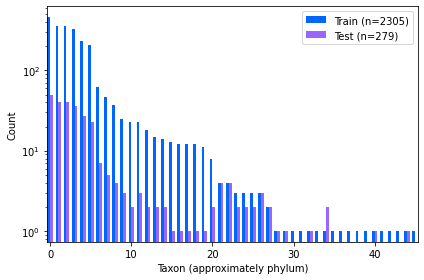

In [26]:
fig, labels, y3 = data_viz.plot_tax_dist(c_train_genomes, c_test_genomes)
plt.savefig("/Users/natasha/Desktop/fig_dist.png", bbox_inches='tight')

In [27]:
def get_lengths(c_genomes, org_to_kos):
    lens = []
    for i in list(set(c_genomes)):
        tnum = tla_to_tnum[i]
        lens.append(len(org_to_kos[tnum]))
    return lens

train_lens = get_lengths(c_train_genomes, org_to_kos)
test_lens = get_lengths(c_test_genomes, org_to_kos)

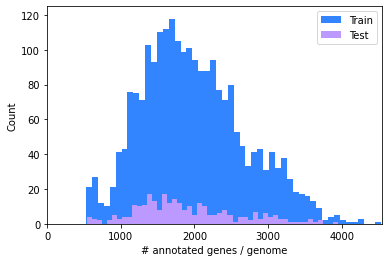

In [28]:
# Plot the number of KOs encoded by each genome
fig, ax = plt.subplots()
plt.hist(train_lens, 50, color='#3385ff')
plt.hist(test_lens, 50, color='#bb99ff')
ax.legend(['Train', 'Test'])
plt.xlabel("# annotated genes / genome")
plt.ylabel("Count")
plt.savefig("/Users/natasha/Desktop/fig.png")
plt.ylim(0,125)
plt.xlim(0,max(train_lens)+10)
plt.savefig("/Users/natasha/Desktop/fig_ko_dist.png", bbox_inches='tight')

Text(0, 0.5, 'Number of genomes')

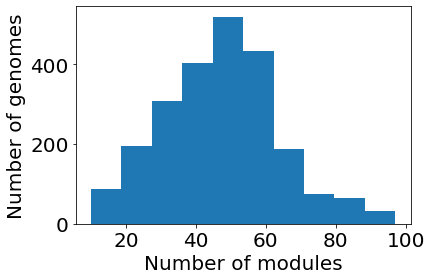

In [361]:
# How many modules are there per training genome?
from collections import defaultdict
mods_count = defaultdict(int)
for org in org_to_mod_to_kos:
    if org in c_train_genomes:
        mods_count[org] = len(org_to_mod_to_kos[org])
plt.hist(mods_count.values())
plt.xlabel('Number of modules')
plt.ylabel('Number of genomes')

# Define and train network

In [29]:
# memory = 2000 * 1024 * 1024
# object_store_memory = 200 * 1024 * 1024
# driver_object_store_memory=100 * 1024 * 1024
# ray.shutdown()
# ray.init(local_mode=True, memory=memory, 
#         object_store_memory=object_store_memory,
#         driver_object_store_memory=driver_object_store_memory,
#         num_cpus=10)

In [30]:
# config = {"num_epochs": 10,
#          "kfolds": 10,
#          "replacement_threshold": settings.replacement_threshold,
#          "nn_layers": tune.choice([1, 2, 3, 4]),
#          "batch_size": tune.choice([32, 64, 128, 256]),
#           "lr": tune.loguniform(1e-4, 1e-1), 
#           "weight_decay": tune.loguniform(1e-5, 1e-2) 
#          }

In [31]:
# analysis = tune.run(
#     trainable.train_AE, 
#     name="sept_22_vae",
#     config=config,
#     verbose=2, 
#     resources_per_trial={
#             "cpu": 10,
#             "gpu": 0
#     },
#     num_samples=20,  
#     queue_trials=True,
#     #local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR",
#     local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_01-10-2020/TUNE_RESULT_DIR"
#     )

In [32]:
# print("Best config is:", analysis.get_best_config(metric="test_f1"))

In [33]:
# analysis.get_best_config(metric="test_f1")

# Train

In [34]:
# trainable.train_single_dae(3, 0.01, 0.001, 128, 10, 10, 0.5)

In [35]:
nn_layers = 3
weight_decay = 0.1
lr = 0.001
batch_size = 128
kfolds = 10
num_epochs = 10
replacement_threshold = 0.5

kld0, bce0, train_losses, test_losses, train_f1s, test_f1s, model = trainable.train_single_vae(nn_layers, weight_decay, lr, batch_size, kfolds, num_epochs, replacement_threshold, corrupted_train, corrupted_test)


11:32
epoch 0 batch 0
train_loss 891798.875 train_f1 0.2190348632981509 test_loss 5996903.0 test_f1 0.3696572737139628
epoch 0 batch 100
train_loss 243514.921875 train_f1 0.7126887089100874 test_loss 1955317.5 test_f1 0.692845571255306
epoch 0 batch 200
train_loss 218533.171875 train_f1 0.7380765031872398 test_loss 1727004.75 test_f1 0.7350486664599292
epoch 0 batch 300
train_loss 204034.109375 train_f1 0.7528183424419336 test_loss 1606771.625 test_f1 0.7542641288258867
epoch 0 batch 400
train_loss 197692.71875 train_f1 0.7693387491199928 test_loss 1580456.25 test_f1 0.7648110478847349
epoch 0 batch 500
train_loss 187231.109375 train_f1 0.7665193549176508 test_loss 1538906.25 test_f1 0.766871084800171
epoch 0 batch 600
train_loss 199012.875 train_f1 0.7697927691121058 test_loss 1478265.625 test_f1 0.7797114489301009
epoch 0 batch 700
train_loss 190405.0625 train_f1 0.7840024989387906 test_loss 1467624.875 test_f1 0.7789868082173517
epoch 0 batch 800
train_loss 180497.0625 train_f1 0.78

epoch 4 batch 200
train_loss 134368.515625 train_f1 0.8543703616128551 test_loss 1031514.625 test_f1 0.8560545790180072
epoch 4 batch 300
train_loss 131386.984375 train_f1 0.8564707611712056 test_loss 1042050.625 test_f1 0.8539009778839244
epoch 4 batch 400
train_loss 129388.203125 train_f1 0.8624774145298597 test_loss 1042584.125 test_f1 0.8542591094294758
epoch 4 batch 500
train_loss 128093.140625 train_f1 0.8592565272208451 test_loss 1013984.375 test_f1 0.8599754446034686
epoch 4 batch 600
train_loss 132481.765625 train_f1 0.8575594923235593 test_loss 1048379.0 test_f1 0.8531339120272551
epoch 4 batch 700
train_loss 133786.203125 train_f1 0.8621730141674878 test_loss 1014257.6875 test_f1 0.8581643677223282
epoch 4 batch 800
train_loss 124863.203125 train_f1 0.863701223218466 test_loss 52224.81640625 test_f1 0.8560817276085215
epoch 4 batch 900
train_loss 123559.1328125 train_f1 0.8686427108021326 test_loss 1042009.6875 test_f1 0.8551630335457394
epoch 4 batch 1000
train_loss 130277.

epoch 8 batch 300
train_loss 110018.9765625 train_f1 0.881869723756525 test_loss 944716.6875 test_f1 0.869969554285258
epoch 8 batch 400
train_loss 113374.1640625 train_f1 0.8753147240712381 test_loss 916048.5 test_f1 0.8737444504455849
epoch 8 batch 500
train_loss 112327.6484375 train_f1 0.8773053144859178 test_loss 917705.375 test_f1 0.8746514474515524
epoch 8 batch 600
train_loss 113016.0703125 train_f1 0.8743006446728405 test_loss 907927.8125 test_f1 0.876121521417478
epoch 8 batch 700
train_loss 120038.9375 train_f1 0.872959533583943 test_loss 957809.25 test_f1 0.8681380640024389
epoch 8 batch 800
train_loss 107502.7421875 train_f1 0.8839461417357616 test_loss 958414.6875 test_f1 0.8683512188676143
epoch 8 batch 900
train_loss 116757.03125 train_f1 0.8798076557225171 test_loss 938970.5 test_f1 0.8725707984299165
epoch 8 batch 1000
train_loss 126089.921875 train_f1 0.8689668675837502 test_loss 912791.375 test_f1 0.8749658457904402
epoch 8 batch 1100
train_loss 108124.3671875 train_

In [36]:
torch.save(model.state_dict(), "/Users/natasha/Desktop/model.pt")
torch.save(train_losses, "/Users/natasha/Desktop/train_losses.pt")
torch.save(test_losses, "/Users/natasha/Desktop/test_losses.pt")
torch.save(bce0, "/Users/natasha/Desktop/bce0.pt")
torch.save(kld0, "/Users/natasha/Desktop/kld0.pt")
torch.save(train_f1s, "/Users/natasha/Desktop/train_f1s.pt")
torch.save(test_f1s, "/Users/natasha/Desktop/test_f1s.pt")

In [37]:
load_model = True
if load_model:
    from genome_embeddings import models
    n_features = int(corrupted_train.shape[1]/2)
    model = models.VariationalAutoEncoder(n_features, 3)
    model.load_state_dict(torch.load("/Users/natasha/Desktop/model.pt"))
    model.eval()

# Evaluate model performance

### Generate predictions on test set

In [140]:
# 1-10 modules per input genome: 0.74
# 1 module per input genome: 0.64
# 10 modules per input genome: 0.81
n_features = int(corrupted_test.shape[1]/2)
corrupted = corrupted_test[:,:n_features]
uncorrupted = corrupted_test[:,n_features:]

In [146]:
model.eval()
with torch.no_grad():
    pred = model.forward(corrupted)[0].detach()
binary_pred = evaluate.eval_binarize(pred, 0.5)

### Investigate test set F1 score (micro-average) and calculate TNs, FPs, FNs, TPs

In [506]:
f1 = sk.metrics.f1_score(uncorrupted, binary_pred, zero_division=0, average='micro')
print("Test set F1 score",f1)

0.817927443125047


median F1 score: 0.8260179091731137 min 0.47744196233026726 max 0.9894606323620583


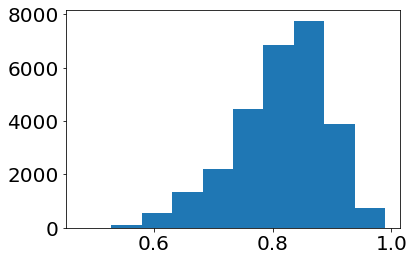

In [507]:
f1s, fig = evaluate.test_f1s(uncorrupted, binary_pred)

In [41]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, binary_pred)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


83.01 2.26 2.97 11.76


### Examine at BCE vs KLD loss

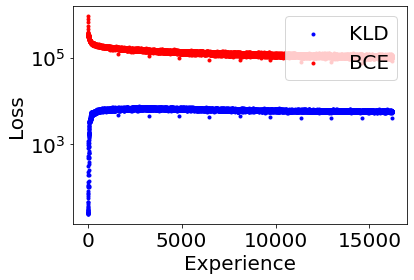

In [505]:
# Plot BCE and KLD vs experience
data_viz.kld_vs_bce(kld0,bce0)

### Plot learning curves

max F1 score 0.8945536345716779


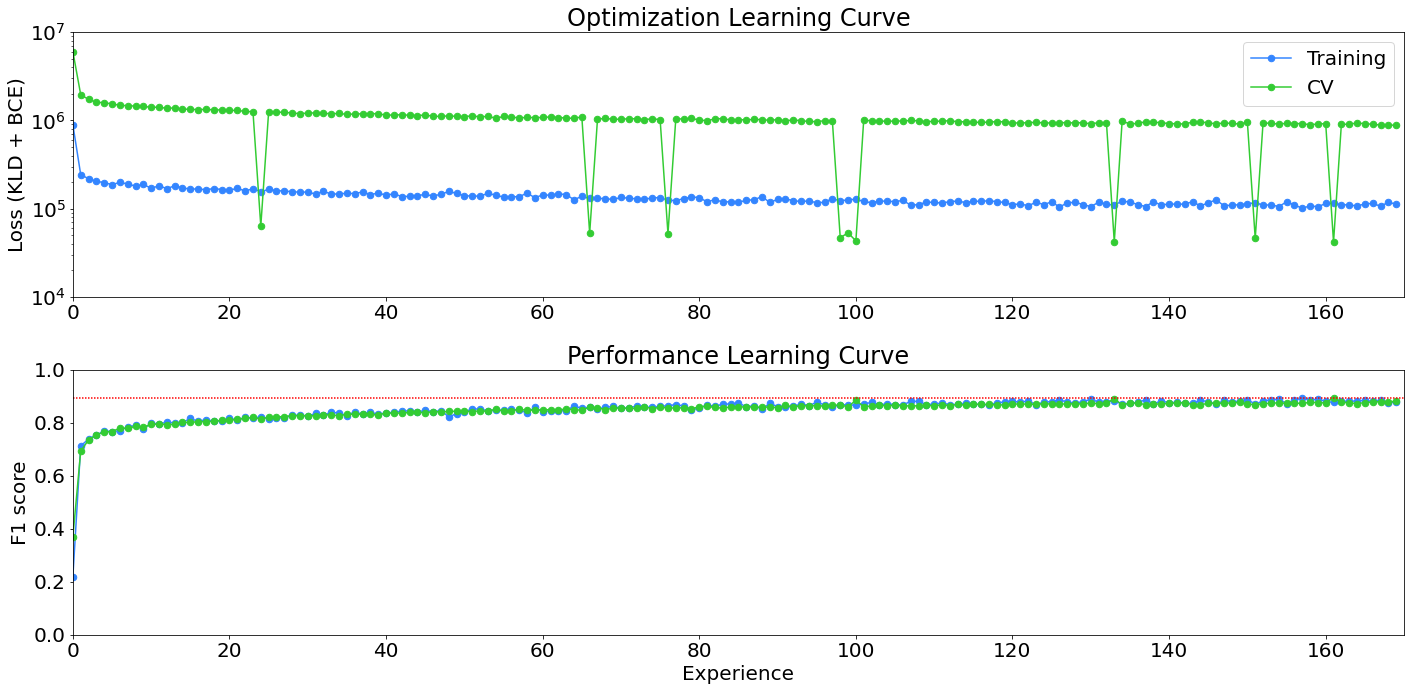

In [945]:
fig = data_viz.learning_curve(train_losses, test_losses, train_f1s, test_f1s)
plt.savefig("/Users/natasha/Desktop/learning_curves.png", bbox_inches='tight')

### Plot ROC curve and generate AUC score (micro-average)

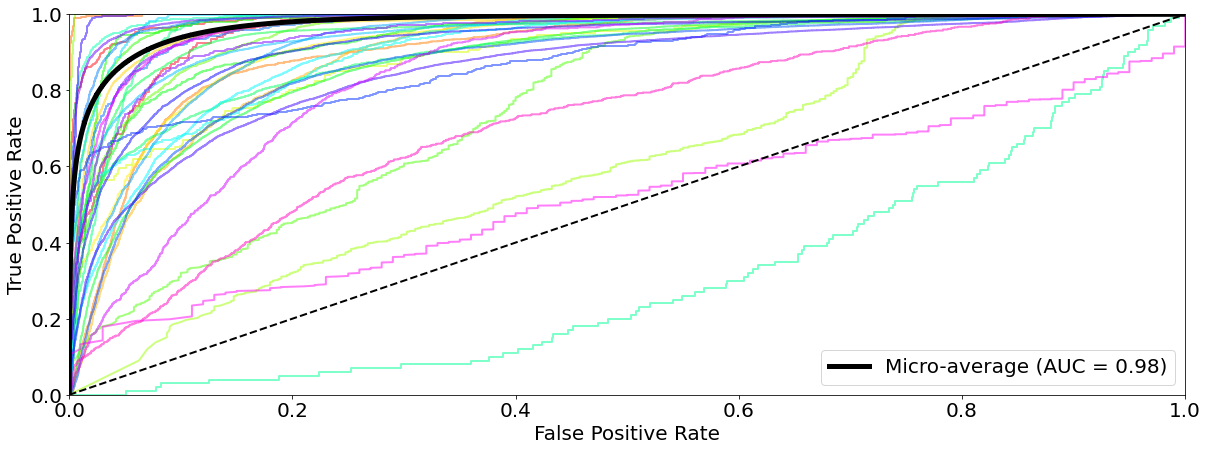

In [242]:
num_features = int(corrupted_test.shape[1]/2)
true_genomes = corrupted_test[:,num_features:]
fig = data_viz.my_roc_curve(true_genomes.numpy(), pred.numpy())
fig.savefig("/Users/natasha/Desktop/roc_fig.png", dpi=200, bbox_inches='tight')

### Are the input genes present in the output?

There are 5685 instance of inputs being 100% present in output
This is out of 27900 instances or 20.38% of cases
There are 23508 instance of inputs being >=90% present in output (84.26%)


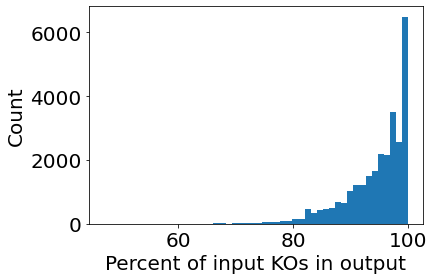

In [497]:
fig = evaluate.compare_in_n_out(binary_pred, corrupted)

### What are the best and worst performing instances?

In [923]:
# babt = Brucella abortus
idx_best = f1s.index(max(f1s))
tla_best = c_test_genomes[idx_best]
idx_best, tla_best, f1s[idx_best], tla_to_tnum[tla_best]

(3638, 'babt', 0.9894606323620583, 'T03461')

In [922]:
# nmv = Nitrospira moscoviensis
# seny = Pectobacteriaceae sodalis (Gammaprot), endosymbiont of Henestaris halophilus
idx_worst = f1s.index(min(f1s))
tla_worst = c_test_genomes[idx_worst]
idx_worst, tla_worst, f1s[idx_worst], tla_to_tnum[tla_worst]

(21779, 'seny', 0.47744196233026726, 'T05311')

### For the best scoring instance, plot pixel diagram

Num on bits 43
Original num on bits 1608
Pred num on bits 1613
tn 8245 fp 21 fn 16 tp 1592
F1 0.9885128841974542
9874
n_features 9874 len(colour_pred) 9874 n_extension 26
9900


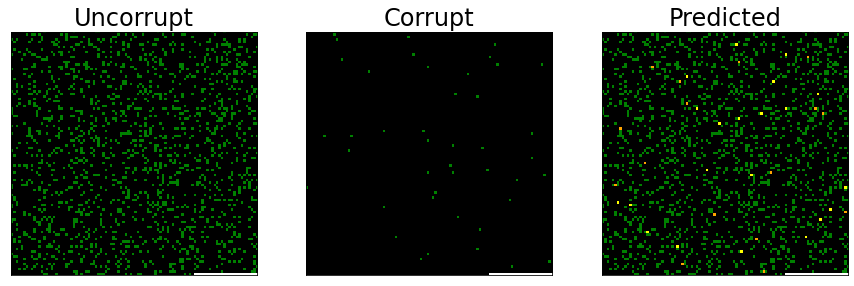

In [503]:
idx = idx_best
fig = data_viz.genome_heatmap2(corrupted_test, idx, model)
fig.savefig("/Users/natasha/Desktop/fig4.png", bbox_inches='tight', dpi=200)

In [504]:
print("Num genes on in uncorrupted idx_best genome", torch.sum(uncorrupted[idx_best,:]))
print("Num genes off in uncorrupted idx_best genome", n_features - torch.sum(uncorrupted[idx_best,:]))
print("Num genes on in corrupted idx_best genome", torch.sum(corrupted[idx_best,:]))

Num genes on in uncorrupted idx_best genome tensor(1608.)
Num genes off in uncorrupted idx_best genome tensor(8266.)
Num genes on in corrupted idx_best genome tensor(43.)


### How does the model perform on inputs originating from different phyla

In [259]:
# get dicts to map genome tla back to list of phylum, class, etc
train_tax_dict, test_tax_dict = data_viz.tax_distribution(c_train_genomes, c_test_genomes)

In [512]:
train_phyla, test_phyla = evaluate.f1s_per_phylum(train_tax_dict, test_tax_dict, c_test_genomes, f1s)

Best: Deinococcus-Thermus 0.9066665499706801
Worst: Acidobacteria 0.6343371138052405


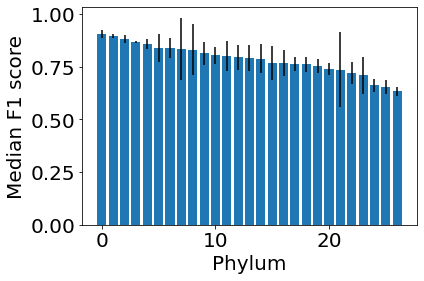

In [526]:
# Bars represent median absolute deviation
fig = evaluate.plot_f1_per_phylum(test_phyla)

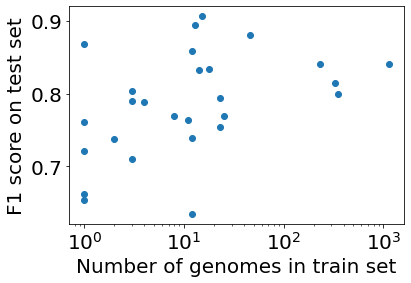

In [514]:
fig = evaluate.plot_count_vs_f1s(train_phyla, test_phyla)

There appears to be an effect of number of training genomes / phylum on test set per phylum F1 score 

### How many times is each mod used in the various corrupted inputs?

In [528]:
# Number of times each mod occurs in the training set corrupted genomes
train_out = evaluate.train_out(train_input_mods)

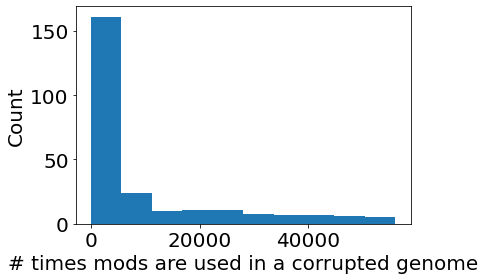

In [529]:
fig = evaluate.plot_train_count_hist(train_out)

### How does genome size correlate with F1 score

In [ ]:
# x-axis = # genes in input genome
# y-axis = F1 score of reconstructed genomes

In [978]:
n_genes_uncorrupted = torch.sum(uncorrupted, 1).numpy().tolist() # get sum of each row

Text(0, 0.5, 'F1 score')

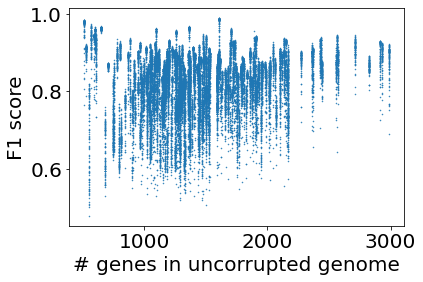

In [986]:
plt.scatter(n_genes_uncorrupted, f1s, marker='.', s = 1)
plt.xlabel("# genes in uncorrupted genome")
plt.ylabel("F1 score")

In [987]:
n_genes_corrupted = torch.sum(corrupted, 1).numpy().tolist() # get sum of each row

Text(0, 0.5, 'F1 score')

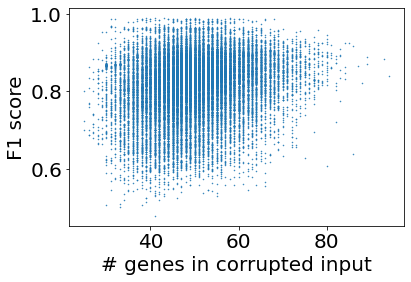

In [990]:
plt.scatter(n_genes_corrupted, f1s, marker='.', s = 1)
plt.xlabel("# genes in corrupted input")
plt.ylabel("F1 score")

### How much variance is there in the F1 score of genomes encoding certain modules?
Do some modules / lifestyles get reconstructed better than others?

In [907]:
process_to_mod, mod_to_proc = evaluate.map_proc_mod()

In [955]:
#fig, done = evaluate.plot_mod_count_vs_f1(test_input_mods, c_test_genomes, train_input_mods, f1s)

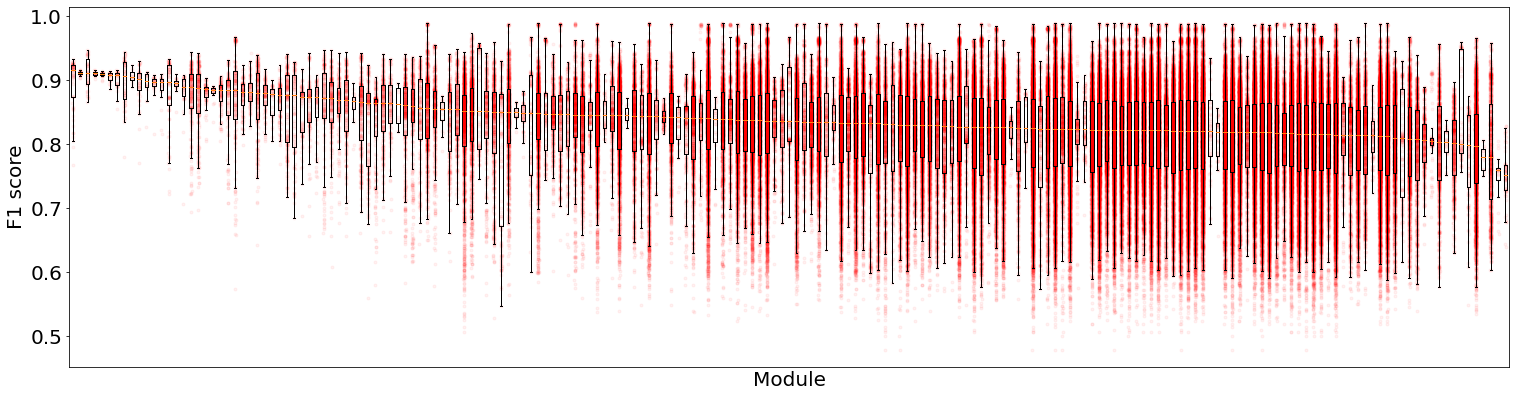

In [911]:
fig = evaluate.plot_mod_vs_f1(test_input_mods, f1s)

In [ ]:
# Plot whether number of modules in process correlates with F1 score
# More interchangeable options = worse performance?

In [919]:
subprocess_to_mod, mod_to_subproc = evaluate.map_subproc_mod()

In [1067]:
# fig = evaluate.plot_metab_pathway_f1(subprocess_to_mod, test_input_mods, f1s)

### Analyze F1 scores of actual KOs

In [926]:
### THIS MUST BE USED IN MULTIPLE PLACES
ko_f1s = []
for i in range(uncorrupted.shape[1]): # for every column
    f1 = sk.metrics.f1_score(uncorrupted[:,i], binary_pred[:,i], zero_division=0)
    ko_f1s.append(f1)

In [944]:
zeros = 0
for i in ko_f1s:
    if i == 0:
        zeros += 1
print(zeros, len(ko_f1s), zeros/len(ko_f1s)*100)

2221 9874 22.493417054891633


In [954]:
# In the training set, how many KOs are always zero?
zeros_train = train_data.sum(axis=0) > 0
n_ones = np.sum(n_zeros_train)
n_zeros_train = len(zeros_train) - n_ones
print("There are",n_zeros_train,"genes that are always off in the training set")

There are 9791 genes that are always off in the training set


Text(0, 0.5, 'Count')

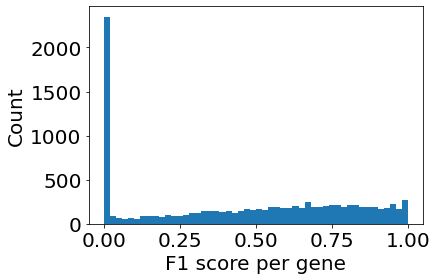

In [943]:
fig = plt.figure()
plt.hist(ko_f1s, bins = 50)
plt.xlabel("F1 score per gene")
plt.ylabel("Count")

max KO count: 230300 , total number of training genomes: 230500


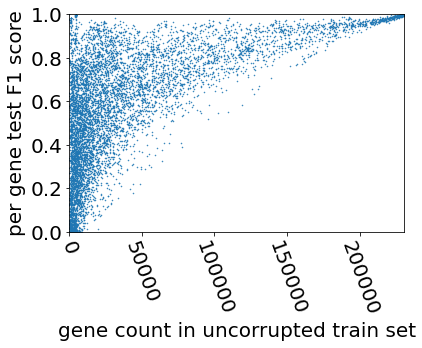

In [1011]:
# gene occurence in uncorrupted ds vs F1 score
#ko_counts = torch.sum(uncorrupted, 0)
# get gene occurence in uncorrupted training set
tr_uncorrupted = corrupted_train[:,n_features:]
ko_counts = torch.sum(tr_uncorrupted, 0)

fig, ax = plt.subplots()
plt.scatter(ko_counts, ko_f1s, marker='.', s = 1)
ax.set_xlim(0, tr_uncorrupted.shape[0])
ax.set_ylim(0,1)
plt.xlabel("gene count in uncorrupted train set")
plt.ylabel("per gene test F1 score")
plt.xticks(rotation=-70)
print("max KO count:",int(max(ko_counts)), ", total number of training genomes:",tr_uncorrupted.shape[0])

In [ ]:
# F1 score on KOs + what metab pathway they are part of

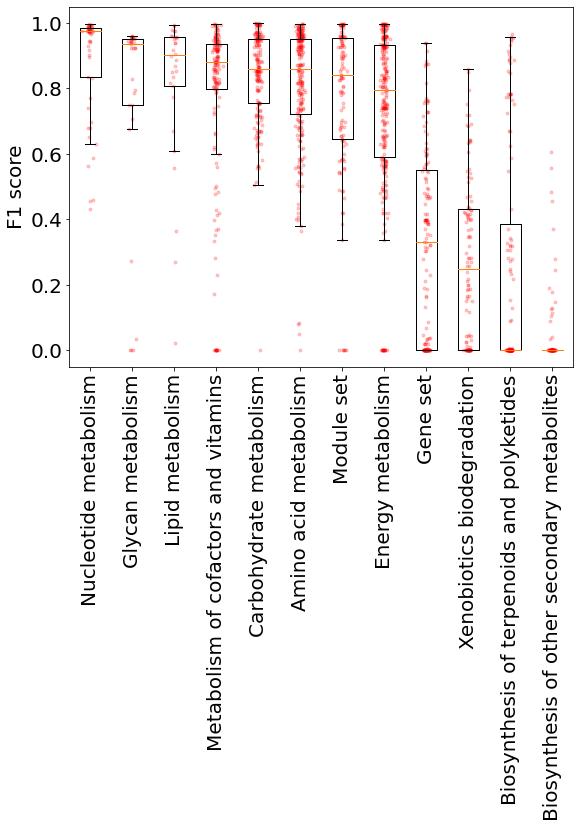

In [1048]:
fig = evaluate.plot_metab_pathway_f1_v2(process_to_mod, mod_to_kos, all_kos, ko_f1s, (7,5))

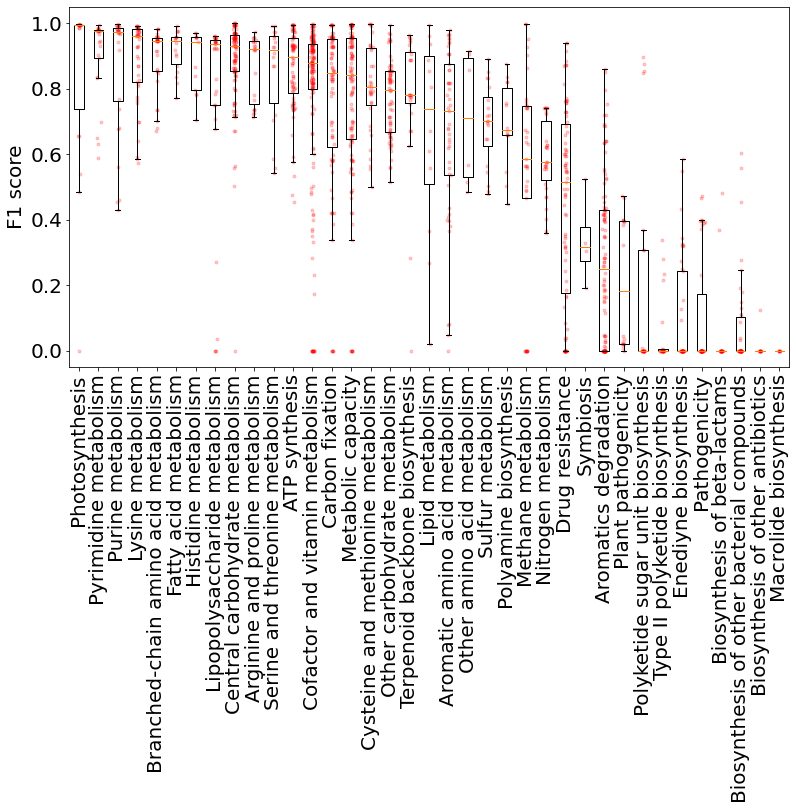

In [1049]:
fig = evaluate.plot_metab_pathway_f1_v2(subprocess_to_mod, mod_to_kos, all_kos, ko_f1s, (10,5))

In [ ]:
### How does the model do on different types of genes (kinases vs transferases, etc) 

### How does the count of each mod in training set (pre-corruption) correlate with median F1 score

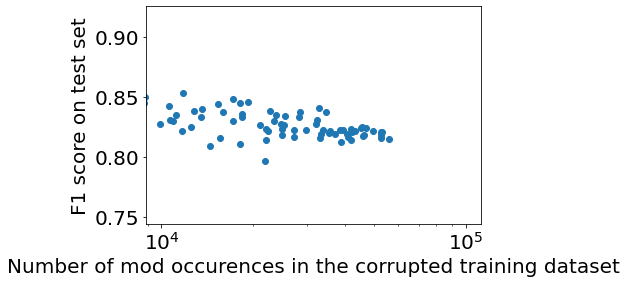

In [550]:
fig = evaluate.plot_mod_count_vs_f1_v2(test_input_mods, f1s, train_out)

# Baseline models

In [ ]:
import sklearn as sk
from sklearn.metrics import confusion_matrix

### Baseline 1: randomly turn on n_rand bits

In [ ]:
new = False

if new:
    print("Generating new baseline 1")
    baseline1 = evaluate.baseline1(corrupted_train, org_to_mod_to_kos, org_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline1, "/Users/natasha/Desktop/baseline1.pt")
else:
    print("Loading previously made baseline 1")
    baseline1 = torch.load("/Users/natasha/Desktop/baseline1.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline1, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline1)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline1.numpy())

### Baseline 2: randomly turn on n_rand bits with the highest probability of being on across the entire training set

In [ ]:
new = True

if new:
    print("Generating new baseline 2")
    baseline2 = evaluate.baseline2(corrupted_test, org_to_mod_to_kos, org_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline2, "/Users/natasha/Desktop/baseline2.pt")
else:
    print("Loading previously made baseline 2")
    baseline2 = torch.load("/Users/natasha/Desktop/baseline2.pt")
    

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline2, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline2)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline2.numpy())

### Baseline 3: Create predictions using an untrained version of the VAE model

In [ ]:
new = True

if new:
    print("Generating new baseline 3")
    n_features = int(corrupted_test.shape[1]/2)
    fake_model = models.VariationalAutoEncoder(n_features, 3)
    fake_model.eval()
    with torch.no_grad():
        pred = fake_model.forward(corrupted_test[:,:n_features])[0].detach()
    baseline3 = evaluate.eval_binarize(pred, 0.5)
    torch.save(baseline3, "/Users/natasha/Desktop/baseline3.pt")
else:
    print("Loading previously made baseline 3")
    baseline3 = torch.load("/Users/natasha/Desktop/baseline3.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted.long(), baseline3.long(), zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline3)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline3.numpy())

### Baseline 4: Always predict the smallest genome in the training set (Hoaglandella endobia -- hed)

In [ ]:
new = True

if new:
    print("Generating new baseline 4")
    baseline4 = evaluate.baseline4(corrupted_train, corrupted_test, tla_to_tnum, org_to_kos, c_train_genomes)
    torch.save(baseline4, "/Users/natasha/Desktop/baseline4.pt")
else:
    print("Loading previously made baseline 4")
    baseline4 = torch.load("/Users/natasha/Desktop/baseline4.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline4, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline4)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline4.numpy())

### Baseline 5: Always predict the largest genome in the training set (Paraburkholderia caribensis -- bcai)

In [ ]:
new = True

if new:
    print("Generating new baseline 5")
    baseline5, largest_tla = evaluate.baseline5(corrupted_train, corrupted_test, tla_to_tnum, org_to_kos, c_train_genomes)
    torch.save(baseline5, "/Users/natasha/Desktop/baseline5.pt")
else:
    print("Loading previously made baseline 5")
    baseline5 = torch.load("/Users/natasha/Desktop/baseline5.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline5, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline5)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline5.numpy())

# Potential model improvements

In [ ]:
# Increase dataset set (more corruptions per genome)
# For genomes it does poorly on, make more copies
# HP tuning
# Remove genomes with <1000 KOs ---> get rid of endosymbionts --- will need to redo small genome baseline
# Apply different amounts of KLD importance during training
# Make 100% of input genes in output (currently ~20% have 100% in and out). Loss mod?

In [ ]:
# We performed a parameter sweep over warmups (κ) (0.01, 0.05, 0.1, and 1). 
# κ controls how much the KL divergence loss contributes to learning, 
# which effectively transitions a deterministic autoencoder to a VAE.28,29 
# For instance, a κ = 0.1 would add 0.1 to a weight on the KL loss after each epoch. 
# After 10 epochs, the KL loss will have equal weight as the reconstruction loss. 
# We did not observe κ to influence model training (Figure 1B), so we kept κ = 1 for downstream analyses.

# Model output to KAAS input

In [1179]:
save_to = '/Users/natasha/Desktop/prot_out.txt'
ko_new = evaluate.new_genome_random(mod_to_kos, model, all_kos, save_to)

In [1180]:
len(ko_new)

2183